In [1]:
import numpy as np  # import auxiliary library, typical idiom
import pandas as pd  # import the Pandas library, typical idiom
from numba import jit
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from tqdm.keras import TqdmCallback
import seaborn as sns

In [3]:
df = pd.read_csv('export2018.csv')

In [4]:
df = df.sort_values(by=['case','startTime'])
df = df.reset_index()

In [60]:
df

,index,case,event,startTime,completeTime,penalty_JLP1,penalty_JLP3,number_parcels,penalty_JLP2,penalty_JLP5,...,note,eventid,activity,docid,subprocess,event_identity:id,doctype,docid_uuid,org:resource,success
0,136988,0002505cb62792e4,mail income,2015/04/28 00:00:00.000,2015/04/28 00:00:00.000,False,False,22,False,False,...,none,NaN,mail income,-18008611496170460,Application,B6B85303-95A4-46D7-9B91-0368E1958061,Payment application,D48C1FCD-AEDA-48DD-9088-3E719879189E,0;n/a,True
1,136989,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail valid,-18008615298987186,Main,FD660BDA-27EC-4A77-81C1-8EDA69E6B569,Entitlement application,69497527-B2B8-4787-A5D8-FA7CF2DEDC9E,0;n/a,True
2,136990,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail valid,-18008611496170460,Application,D286897C-2B80-41B1-B8DA-8F74C94C43F4,Payment application,D48C1FCD-AEDA-48DD-9088-3E719879189E,0;n/a,True
3,136991,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail valid,-18008615298987186,Main,BF00997A-C726-42E3-ABCC-F10EE4F4E79B,Entitlement application,69497527-B2B8-4787-A5D8-FA7CF2DEDC9E,0;n/a,True
4,136992,0002505cb62792e4,initialize,2015/06/12 11:50:18.000,2015/06/12 11:50:18.000,False,False,22,False,False,...,none,-1.800866e+16,initialize,-18008662112618632,Main,69707386-3324-4AAB-A679-6DB90BEA93A8,Parcel document,2F2E9CD3-156C-4F92-95DB-4488F0D27D28,Document processing automaton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514261,317369,fffadf8d083df3d5,begin editing,2017/04/25 14:06:50.677,2017/04/25 14:06:50.677,False,False,30,False,False,...,none,-1.441092e+17,begin editing,-18008611495602324,Change,F7E224B5-A096-40F9-8E21-2DE751872907,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514262,317370,fffadf8d083df3d5,calculate,2017/04/25 14:06:57.959,2017/04/25 14:06:57.959,False,False,30,False,False,...,none,-1.441092e+17,calculate,-18008611495602324,Change,BAE85422-6BF9-47DD-B14A-D2F9B25B9CB5,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514263,317371,fffadf8d083df3d5,remove document,2017/04/25 14:07:08.236,2017/04/25 14:07:08.236,False,False,30,False,False,...,change by department,-1.441092e+17,remove document,-18008611495602324,Main,C9BC7B95-5890-4CAA-97E7-67D507FD593B,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514264,317372,fffadf8d083df3d5,insert document,2017/04/25 14:07:14.577,2017/04/25 14:07:14.577,False,False,30,False,False,...,manual note,-1.441092e+17,insert document,-18008611495602324,Main,3BA6D516-9D26-4655-BC9C-AA66A36A86A1,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True


In [6]:
df_next_event = df.copy()

#A function for determining the true next event for each event
@jit(parallel = True)
def calculator_nb(case, event):
    res = np.empty(len(case), dtype=object)
    idx = 0
    for _ in case:
        if (idx+1 >= len(case)):
            break
       
        if (case[idx + 1] == case[idx]):
            res[idx] = event[idx + 1]

        idx+=1
    return res

df_next_event['next_event'] = calculator_nb(df_next_event['case'].values, df_next_event['event'].values)

C:\Users\mikok\AppData\Local\Temp\ipykernel_10556\3644305937.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_10556\3644305937.py", line 6:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Temp\ipykernel_10556\3644305937.py:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_10556\3644305937.py", line 6:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "calculator_n

In [8]:
goodshit = ['case','event','number_parcels','payment_actual0','area','cross_compliance','penalty_amount0','next_event']
df_reduced = df_next_event.filter(goodshit)

In [5]:
def normalize(df_name, col_name):
    col_as_array = df_name[col_name].to_numpy()
    col_as_array = np.where(col_as_array == 0, 0.5, col_as_array)
    col_as_array_norm = np.log10(col_as_array)
    mean = col_as_array_norm.mean()
    stdev = col_as_array_norm.std()
    epsilon = 0.01
    return (col_as_array_norm - mean) / (stdev + epsilon)

In [6]:
def col_to_millis(col_name):
    col_as_array = df_reduced[col_name].to_numpy()
    col_as_array[:] = [elem[:19] for elem in col_as_array]
    
    result = []
    for date in col_as_array:
        utctime = datetime.strptime(date, "%Y/%m/%d %H:%M:%S")
        result.append((utctime - datetime(1970, 1, 1)) // timedelta(milliseconds=1))
    
    return result

In [9]:
df_reduced = df_reduced.fillna(value="None")

In [14]:
#train, validate, test = np.split(df_reduced.sample(frac=1), [int(.6*len(df_reduced)), int(.8*len(df_reduced))])
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df_reduced)), int(.8*len(df_reduced))])

In [9]:
ordinal_encoder = OrdinalEncoder()
label_encoder = LabelEncoder()

In [10]:
def prepfeatures(df_name):
    event = df_name['event'].to_numpy()
    event = event.reshape(-1,1)
    event = ordinal_encoder.fit_transform(event)
    
    number_parcels = normalize(df_name,'number_parcels')
    payment_actual0 = normalize(df_name,'payment_actual0')
    area = normalize(df_name,'area')
    cross_compliance = normalize(df_name,'cross_compliance')
    penalty_amount0 = normalize(df_name,'penalty_amount0')
    
    features = []
    for i in range(len(event)):
        current = event[i]
        current = np.append(current,number_parcels[i])
        current = np.append(current,payment_actual0[i])
        current = np.append(current,area[i])
        current = np.append(current,cross_compliance[i])
        current = np.append(current,penalty_amount0[i])
        features.append(current)
        
    return np.array(features)

In [11]:
def preplabels(df_name):
    labels = df_name['next_event'].to_numpy()
    labels = label_encoder.fit_transform(labels)
    labels = labels.reshape(-1, 1)
    
    return np.array(labels)

In [12]:
features = prepfeatures(train)
labels = preplabels(train)

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(6,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(35, activation='relu'),
    keras.layers.Dense(42, activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.fit(features,labels,epochs=5,verbose=1)
#model.fit(features,labels,epochs=1,verbose=1)

9375/9375 [==============================] - 12s 1ms/step - loss: 1.6652 - accuracy: 0.4696


In [15]:
features_test = prepfeatures(test)
labels_test = preplabels(test)

In [16]:
score = model.evaluate(features_test, labels_test, verbose=1)
print(score)

3125/3125 [==============================] - 3s 942us/step - loss: 1.5022 - accuracy: 0.4910
[1.5021969079971313, 0.49097999930381775]


In [6]:
df_copy = df.copy()

In [7]:
#A function for determining the true next event for each event
@jit(parallel = True)
def calculator_nb(case, startTime):
    res = np.empty(len(case), dtype=object)
    idx = 0
    for _ in case:
        if (idx+1 >= len(case)):
            break
       
        if (case[idx + 1] == case[idx]):
            res[idx] = startTime[idx + 1]
        else:
            res[idx] = startTime[idx]

        idx+=1
    return res

df_copy['completeTime'] = calculator_nb(df_copy['case'].values, df_copy['startTime'].values)
df_copy.at[2514265, 'completeTime'] = df_copy.at[2514265, 'startTime']

C:\Users\mikok\AppData\Local\Temp\ipykernel_6220\750967705.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_6220\750967705.py", line 4:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Temp\ipykernel_6220\750967705.py:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_6220\750967705.py", line 4:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "calculator_nb" was c

In [8]:
df_copy

,index,case,event,startTime,completeTime,penalty_JLP1,penalty_JLP3,number_parcels,penalty_JLP2,penalty_JLP5,...,note,eventid,activity,docid,subprocess,event_identity:id,doctype,docid_uuid,org:resource,success
0,136988,0002505cb62792e4,mail income,2015/04/28 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail income,-18008611496170460,Application,B6B85303-95A4-46D7-9B91-0368E1958061,Payment application,D48C1FCD-AEDA-48DD-9088-3E719879189E,0;n/a,True
1,136989,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail valid,-18008615298987186,Main,FD660BDA-27EC-4A77-81C1-8EDA69E6B569,Entitlement application,69497527-B2B8-4787-A5D8-FA7CF2DEDC9E,0;n/a,True
2,136990,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/05/04 00:00:00.000,False,False,22,False,False,...,none,NaN,mail valid,-18008611496170460,Application,D286897C-2B80-41B1-B8DA-8F74C94C43F4,Payment application,D48C1FCD-AEDA-48DD-9088-3E719879189E,0;n/a,True
3,136991,0002505cb62792e4,mail valid,2015/05/04 00:00:00.000,2015/06/12 11:50:18.000,False,False,22,False,False,...,none,NaN,mail valid,-18008615298987186,Main,BF00997A-C726-42E3-ABCC-F10EE4F4E79B,Entitlement application,69497527-B2B8-4787-A5D8-FA7CF2DEDC9E,0;n/a,True
4,136992,0002505cb62792e4,initialize,2015/06/12 11:50:18.000,2015/06/12 11:50:18.000,False,False,22,False,False,...,none,-1.800866e+16,initialize,-18008662112618632,Main,69707386-3324-4AAB-A679-6DB90BEA93A8,Parcel document,2F2E9CD3-156C-4F92-95DB-4488F0D27D28,Document processing automaton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514261,317369,fffadf8d083df3d5,begin editing,2017/04/25 14:06:50.677,2017/04/25 14:06:57.959,False,False,30,False,False,...,none,-1.441092e+17,begin editing,-18008611495602324,Change,F7E224B5-A096-40F9-8E21-2DE751872907,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514262,317370,fffadf8d083df3d5,calculate,2017/04/25 14:06:57.959,2017/04/25 14:07:08.236,False,False,30,False,False,...,none,-1.441092e+17,calculate,-18008611495602324,Change,BAE85422-6BF9-47DD-B14A-D2F9B25B9CB5,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514263,317371,fffadf8d083df3d5,remove document,2017/04/25 14:07:08.236,2017/04/25 14:07:14.577,False,False,30,False,False,...,change by department,-1.441092e+17,remove document,-18008611495602324,Main,C9BC7B95-5890-4CAA-97E7-67D507FD593B,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True
2514264,317372,fffadf8d083df3d5,insert document,2017/04/25 14:07:14.577,2017/04/25 14:07:21.285,False,False,30,False,False,...,manual note,-1.441092e+17,insert document,-18008611495602324,Main,3BA6D516-9D26-4655-BC9C-AA66A36A86A1,Payment application,91D58CFF-ACCD-4064-B307-AFB8B7FB9E5E,f9fe07,True


In [9]:
df_copy['startTime'] =  pd.to_datetime(df_copy['startTime'])
df_copy['completeTime'] =  pd.to_datetime(df_copy['completeTime'])

In [10]:
df_copy['duration'] = df_copy['completeTime'] - df_copy['startTime']

In [11]:
df_copy['duration'] = pd.to_numeric(df_copy['duration'])

In [16]:
df_copy.columns

Index(['index', 'case', 'event', 'startTime', 'completeTime', 'penalty_JLP1',
       'penalty_JLP3', 'number_parcels', 'penalty_JLP2', 'penalty_JLP5',
       'year', 'penalty_JLP7', 'penalty_JLP6', 'redistribution',
       'amount_applied1', 'amount_applied0', 'amount_applied3',
       'amount_applied2', 'identity:id', 'penalty_V5', 'payment_actual0',
       'payment_actual2', 'payment_actual1', 'penalty_B5F', 'payment_actual3',
       'penalty_B16', 'penalty_GP1', 'basic payment', 'penalty_AGP', 'area',
       'selected_manually', 'penalty_B3', 'penalty_B2', 'selected_risk',
       'penalty_B5', 'penalty_AVBP', 'penalty_B4', 'penalty_B6', 'penalty_ABP',
       'penalty_AVGP', 'penalty_C4', 'greening', 'rejected',
       'cross_compliance', 'penalty_C9', 'penalty_AVJLP', 'penalty_CC',
       'penalty_AVUVP', 'penalty_BGK', 'penalty_C16', 'penalty_BGP',
       'department', 'small farmer', 'risk_factor', 'applicant',
       'penalty_AUVP', 'penalty_amount2', 'penalty_BGKV', 'penalty_amo

<AxesSubplot:xlabel='penalty_amount0', ylabel='duration'>

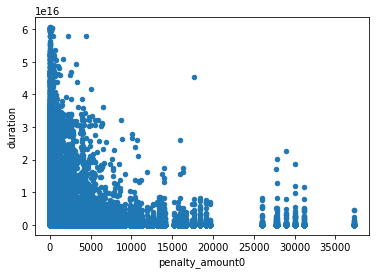

In [35]:
df_copy.plot.scatter(x='penalty_amount0',y='duration')

In [39]:
startTime = pd.to_numeric(df_copy['startTime']).to_numpy()
number_parcels = df_copy['number_parcels'].to_numpy()
amount_applied1 = df_copy['amount_applied1'].to_numpy()
penalty_amount0 = df_copy['penalty_amount0'].to_numpy()
payment_actual0 = df_copy['payment_actual0'].to_numpy()

In [ ]:
X = []
for i in range(len(startTime)):
    current = startTime[i]
    current = np.append(current, number_parcels[i])
    current = np.append(current, amount_applied1[i])
    current = np.append(current, penalty_amount0[i])
    current = np.append(current, payment_actual0[i])
    X = np.append(X, current)

In [76]:
#A function for determining the true next event for each event
@jit(parallel = True)
def calculator_nb(case, duration):
    res = np.empty(len(case), dtype=object)
    idx = 0
    cumulative = 0
    for _ in case:
        if (idx+1 >= len(case)):
            break
       
        if (case[idx + 1] == case[idx]):
            cumulative = duration[idx] + cumulative
            res[idx] = cumulative
        else:
            res[idx] = cumulative
            cumulative = 0

        idx+=1
    return res

df_copy['duration_cumulative'] = calculator_nb(df_copy['case'].values, df_copy['duration'].values)

C:\Users\mikok\AppData\Local\Temp\ipykernel_10556\1647139393.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_10556\1647139393.py", line 4:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Temp\ipykernel_10556\1647139393.py:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "calculator_nb" failed type inference due to: Untyped global name 'object': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_10556\1647139393.py", line 4:
<source missing, REPL/exec in use?>

  @jit(parallel = True)
C:\Users\mikok\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "calculator_n

<AxesSubplot:>

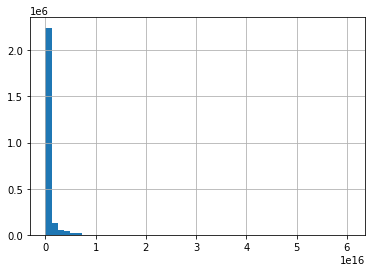

In [16]:
df_copy['duration'].hist(bins=50)